<font size="5" color="blue ">**Task 1: Import the necessary libraries :**</font><br>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

<font size="5" color="blue ">**Task 2 : Set Dataset Path**</font><br>

In [2]:
DATA_DIR = "data"
IMG_SIZE = (160, 160)
BATCH_SIZE = 32


<font size="5" color="blue ">**Task 3 : Load the dataset :**</font><br>

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 2022 files belonging to 2 classes.
Using 1618 files for training.
Found 2022 files belonging to 2 classes.
Using 404 files for validation.
Classes: ['cat', 'dog']


<font size="5" color="blue ">**Task 4 : Prefetch & Cache :**</font><br>

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


<font size="5" color="blue ">**Task 5 : Data Augmentation :**</font><br>

In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])


<font size="5" color="blue ">**Task 6 : Build Transfer Learning Model :**</font><br>

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base

inputs = layers.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_160 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<font size="5" color="blue ">**Task 7 : Visualize Sample Training Images with Labels :**</font><br>

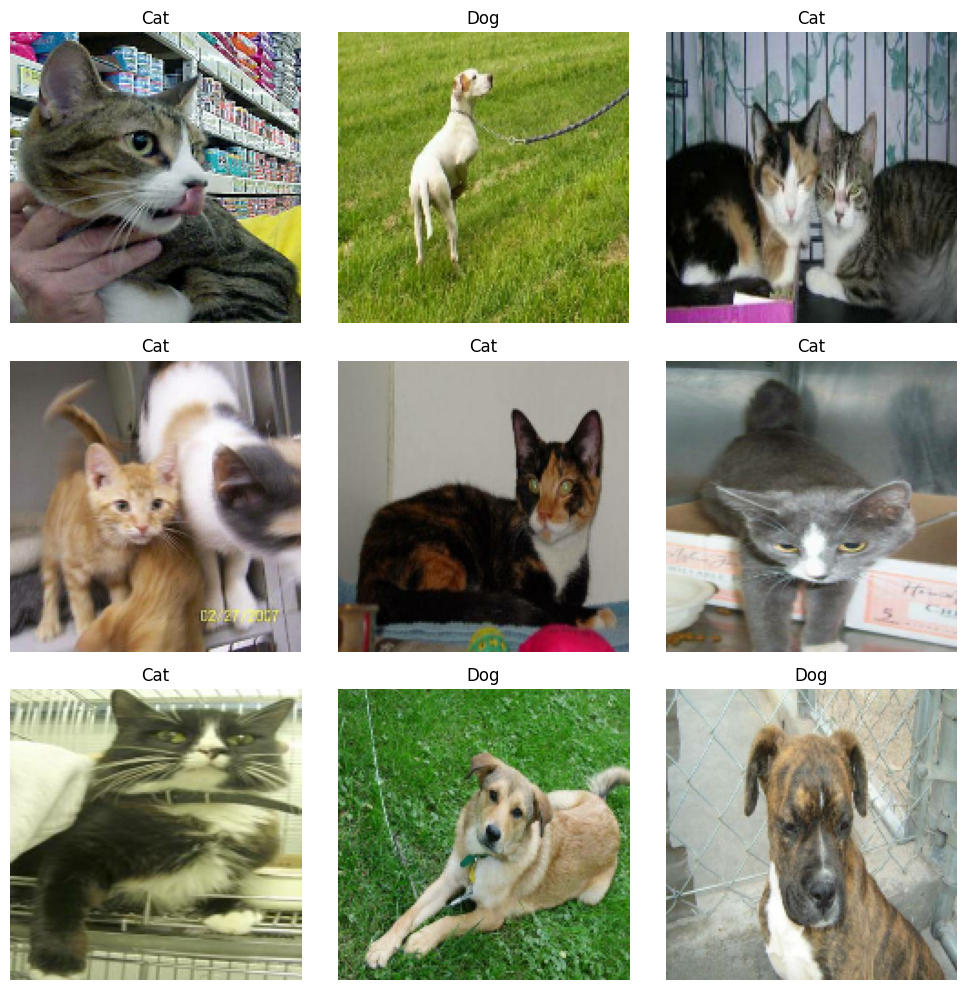

In [7]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.title("Dog" if labels[i].numpy() == 1 else "Cat")
        plt.axis("off")
plt.tight_layout()
plt.show()


<font size="5" color="blue ">**Task 8 : Train the Model :**</font><br>

In [8]:
EPOCHS = 8

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=2
)


Epoch 1/8
51/51 - 24s - 478ms/step - accuracy: 0.9382 - loss: 0.1484 - val_accuracy: 0.9802 - val_loss: 0.0524
Epoch 2/8
51/51 - 17s - 329ms/step - accuracy: 0.9765 - loss: 0.0658 - val_accuracy: 0.9802 - val_loss: 0.0545
Epoch 3/8
51/51 - 16s - 319ms/step - accuracy: 0.9845 - loss: 0.0471 - val_accuracy: 0.9827 - val_loss: 0.0506
Epoch 4/8
51/51 - 17s - 335ms/step - accuracy: 0.9839 - loss: 0.0425 - val_accuracy: 0.9851 - val_loss: 0.0468
Epoch 5/8
51/51 - 16s - 320ms/step - accuracy: 0.9833 - loss: 0.0407 - val_accuracy: 0.9876 - val_loss: 0.0535
Epoch 6/8
51/51 - 17s - 326ms/step - accuracy: 0.9907 - loss: 0.0283 - val_accuracy: 0.9851 - val_loss: 0.0496
Epoch 7/8
51/51 - 16s - 320ms/step - accuracy: 0.9938 - loss: 0.0208 - val_accuracy: 0.9876 - val_loss: 0.0555
Epoch 8/8
51/51 - 16s - 307ms/step - accuracy: 0.9951 - loss: 0.0176 - val_accuracy: 0.9851 - val_loss: 0.0642


<font size="5" color="blue ">**Task 9 : Fine-tuning model (to make it smarter) :**</font><br>

In [9]:
# Unfreeze last 30 layers of MobileNetV2 for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Fine-tuning last 30 layers...")
fine_tune_epochs = 5

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    verbose=2
)


Fine-tuning last 30 layers...
Epoch 1/5
51/51 - 29s - 575ms/step - accuracy: 0.8560 - loss: 0.4646 - val_accuracy: 0.9777 - val_loss: 0.0807
Epoch 2/5
51/51 - 18s - 354ms/step - accuracy: 0.9419 - loss: 0.1591 - val_accuracy: 0.9752 - val_loss: 0.0960
Epoch 3/5
51/51 - 19s - 364ms/step - accuracy: 0.9604 - loss: 0.0940 - val_accuracy: 0.9752 - val_loss: 0.1004
Epoch 4/5
51/51 - 18s - 353ms/step - accuracy: 0.9784 - loss: 0.0611 - val_accuracy: 0.9752 - val_loss: 0.1005
Epoch 5/5
51/51 - 18s - 351ms/step - accuracy: 0.9759 - loss: 0.0655 - val_accuracy: 0.9802 - val_loss: 0.0918


<font size="5" color="blue ">**Task 10 : Plot Accuracy and Loss :**</font><br>

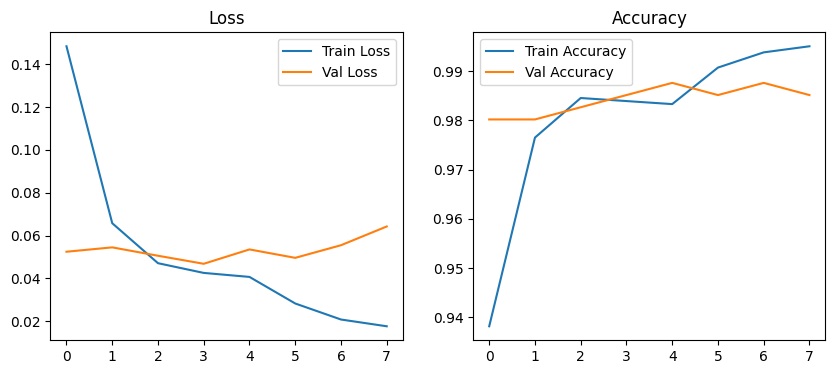

In [10]:
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()


<font size="5" color="blue ">**Task 11 : Evaluate the Model :**</font><br>

In [11]:
loss, acc = model.evaluate(val_ds, verbose=0)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")


✅ Validation Accuracy: 98.02%


<font size="5" color="blue ">**Task 12 : Confusion matrix + show some misclassified examples :**</font><br>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Confusion Matrix:
 [[200   7]
 [  1 196]]

Classification Report:

              precision    recall  f1-score   support

         Cat       1.00      0.97      0.98       207
         Dog       0.97      0.99      0.98       197

    accuracy                           0.98       404
   macro avg       0.98      0.98      0.98       404
weighted avg       0.98      0.98      0.98       404

Misclassified examples: 404 (showing up to 6)


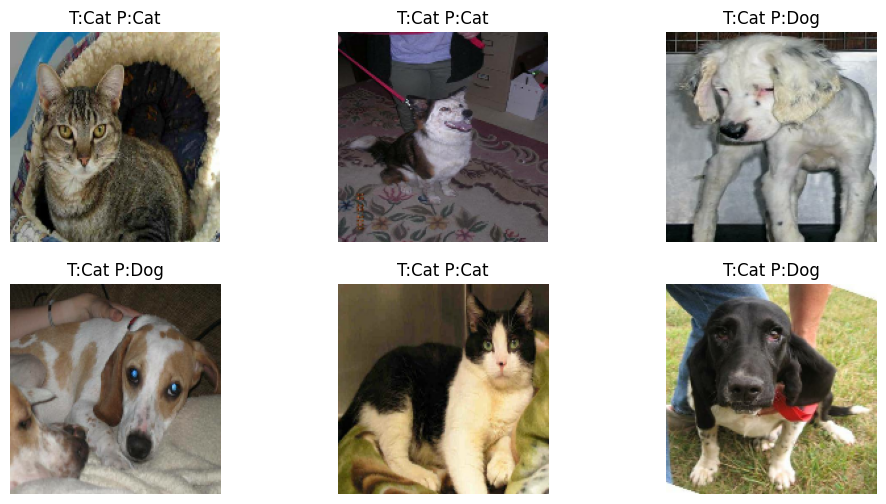

In [12]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Gather true labels and predictions
y_true = []
y_pred = []
imgs = []   # keep images and labels for display
for batch_imgs, batch_labels in val_ds:
    probs = model.predict(batch_imgs)
    preds = (probs.flatten() >= 0.5).astype(int)
    y_true.extend(batch_labels.numpy().astype(int).tolist())
    y_pred.extend(preds.tolist())
    imgs.extend(batch_imgs.numpy())

# Confusion matrix and report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Cat','Dog'], zero_division=0))

# Show up to 6 misclassified images
mis_idx = [i for i,(t,p) in enumerate(zip(y_true,y_pred)) if t!=p]
print(f"Misclassified examples: {len(mis_idx)} (showing up to 6)")
plt.figure(figsize=(12,6))
for i, idx in enumerate(mis_idx[:6]):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(imgs[idx].astype('uint8'))
    plt.axis('off')
    plt.title(f"T:{'Dog' if y_true[idx]==1 else 'Cat'} P:{'Dog' if y_pred[idx]==1 else 'Cat'}")
plt.show()


<font size="5" color="blue ">**Task 13 : Predict on Your Own Image :**</font><br>

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def predict_image(img_path, model, img_size=(160,160)):
    img = cv2.imread(img_path)
    if img is None:
        print("❌ Image not found. Check your path.")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)

    plt.imshow(img)
    plt.axis("off")
    plt.title("Your Image")
    plt.show()

    img_array = np.expand_dims(img, axis=0).astype("float32")
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

    pred = model.predict(img_array)[0][0]
    label = "Dog 🐶" if pred >= 0.5 else "Cat 🐱"
    confidence = pred if pred >= 0.5 else 1 - pred

    print(f"🧠 Prediction: {label}")
    print(f"🎯 Confidence: {confidence*100:.2f}%")
    print(f"Raw probability: {pred:.4f}")


<font size="5" color="blue ">**Task 14 : Test the Model on a Custom Image :**</font><br>

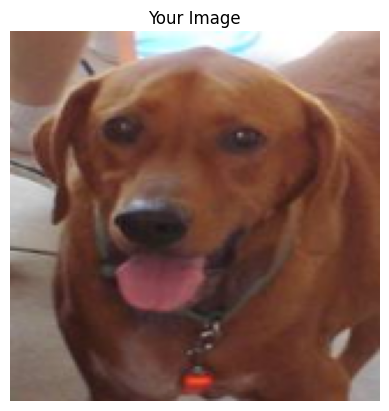

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
🧠 Prediction: Dog 🐶
🎯 Confidence: 87.92%
Raw probability: 0.8792


In [14]:
predict_image(r"C:\Users\Utkarsh Gupta\OneDrive\Desktop\Cat_vs_Dog_Project\data\dog\dog.4014.jpg", model)

<font size="5" color="blue ">**Task 15 : Save Model :**</font><br>

In [15]:
model.save("final_catdog_model.keras")
print("Saved as final_catdog_model.keras")


Saved as final_catdog_model.keras
